In [26]:
import numpy as np
import scipy
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


TITANIC_TRAINING_PATH = "datasets/Titanic/train.csv"
TITANIC_TESTING_PATH = "datasets/Titanic/test.csv"


import warnings
warnings.filterwarnings('ignore')

def load_titanic_data(titanic_path = TITANIC_TRAINING_PATH):
    return pd.read_csv(titanic_path)

tit_test_data = load_titanic_data(TITANIC_TESTING_PATH)
tit_data = load_titanic_data()
tit_data2 = tit_data.copy()

y_train = (tit_data2["Survived"]).values

tit_data2_arr = tit_data2.values
#randomizing
shuffle_index = np.random.permutation(891)    #0 to 890
tit_data2_arr, y_train = tit_data2_arr[shuffle_index], y_train[shuffle_index]
tit_data2 = pd.DataFrame(tit_data2_arr, columns = tit_data2.columns)

#making classes to use in a pipeline
#Tackling Ticket to make TktNum and TktPre and dropping ticket column
class Tackling_Ticket(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, x2, y=None):
        return self
    def transform(self, x2, y=None):
        #appending an 'X' for tickets with no prefix and making two new columns
        x2['Ticket'] = x2['Ticket'].apply(lambda x: x.replace(' ','', 1) if len(x.split()) == 3 else x)
        x2['Ticket'] = x2['Ticket'].apply(lambda x: ('X ' + x ) if len(x.split()) == 1 else x)
        x2[['TktPre', 'TktNum']] = x2.Ticket.str.split(' ', expand = True)
        x2["TktNum"] = x2["TktNum"].replace('LINE', 0)
        x2.drop(['Ticket'], axis = 1, inplace = True)
        return x2

#Divind TktPre in categories so we can use dummies on them
class categorizing_TktPre(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass
    def fit(self, x2, y=None):
        return self
    def transform(self, x2, y=None):
       # print("inside", x2)
        a = x2.TktPre.value_counts().index
        cat1, cat2, cat3 = a[0], a[1:5], a[5:]
        x2["TktPre"] = x2["TktPre"].apply(lambda x: (x in cat1 and 'cat1') or (x in cat2 and 'cat2') or 'cat3')
        return x2

#making dummies of the features
class making_dummies(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, x2, y=None):
        return self
    def transform(self, x2, y=None):
        string_feats = x2[['Sex', 'Embarked', 'TktPre']]
        gd = pd.get_dummies(string_feats)
        x2 = pd.concat([gd, x2.TktNum], axis = 1 )
        return x2

#making catgories for fare and age
class categorizing_Continuous(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass
    def fit(self, x2, y=None):
        return self
    def transform(self, x2, y=None):
        #labels = np.arange(1,21)
        x2 = pd.DataFrame(x2, columns = num_attribs)
        x2["Fare"] = pd.qcut(x2.Fare, q = 5, labels = False)
        #x2["Age"] = pd.qcut(x2.Age, q = 5, labels = False)
        # print(pd.qcut(range(5), 3, labels=["good", "medium", "bad"]))
        #x2.drop('Age', axis = 1, inplace = True)
        return x2


    
#DIviding features in numerical and categorical for Pipelines
num_attribs = ['Pclass','Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Sex', 'Embarked', 'Ticket']

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy = "mean")),
        ('categorizing_continuous', categorizing_Continuous()),
       # ('std_scaler', StandardScaler())
    ])


cat_pipeline = Pipeline([
        ('Tackling_Ticket', Tackling_Ticket()),
        ('categorizing TktPre', categorizing_TktPre()),
        ('Getting_dummies', making_dummies() )
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])


data_prepared = full_pipeline.fit_transform(tit_data2)
print(data_prepared.shape)
columns_prepared = num_attribs + ['Sex_F','Sex_M', 'Em_C', 'Em_Q', 'Em_S', 'Tkt_cat1', 'Tkt_cat2', 'Tkt_cat3', 'TktNum' ]
X_train = pd.DataFrame(data_prepared, columns = columns_prepared)

testing_data_prepared = full_pipeline.fit_transform(tit_test_data)
X_test = pd.DataFrame(testing_data_prepared, columns = columns_prepared)


(891, 14)


In [25]:
#Removing outliers

from collections import Counter
print("training set before removing outliers ", X_train.shape)

#removing otliers from the data
def remove_outlier_rows(f_name_array, given_number, data_name):
    outlier_cols = []
    
    for one_col in f_name_array:
        P1 = np.percentile(data_name[one_col], 25)
        P2 = np.percentile(data_name[one_col], 75)
        IQR = P2 - P1
        outlier_step = 1.5 * IQR
       
        indices_outlier_rows = data_name[(data_name[one_col] > P2 + outlier_step) | (data_name[one_col] < P1 - outlier_step)].index
        #print(X_train[(X_train[one_col] > P2 + IQR) | (X_train[one_col] < P1 - IQR)])
        outlier_cols.extend(indices_outlier_rows)
       
    check = Counter(outlier_cols)
    
    rows_to_remove = [k for k,v in check.items() if v > given_number]
  
    print(X_train["Fare"][rows_to_remove])
    data_name.drop(rows_to_remove, inplace = True)
    return rows_to_remove

rows_removed_train = remove_outlier_rows(["Age", "Parch", "SibSp", "Fare"], 2, X_train)

y_train = np.delete(y_train, rows_removed_train, 0)

print("training set after removing outliers ",X_train.shape)
print("training labels shape ", y_train.shape) 

training set before removing outliers  (891, 13)


KeyError: 'Age'

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

forest_clf = RandomForestClassifier(random_state = 42)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
params = {
    'n_estimators': randint(1, 50),
     'max_features': randint(1, 14),
     'oob_score' : [True],
     'criterion': ['gini', 'entropy']
}

newgridsearch = RandomizedSearchCV(forest_clf, param_distributions = params, n_iter=20, cv = 5, scoring='accuracy')
r_grid_search = newgridsearch.fit(X_train, y_train)

final_model = newgridsearch.best_estimator_
frst_scrs = cross_val_score(final_model, X_train, y_train, cv = 3, scoring = "accuracy")
#print("(Random Forest)", frst_scrs)
frst_scrs.mean()*100

80.92031425364759

In [29]:
#running on the test_Data
final_model = newgridsearch.best_estimator_
letsee = final_model.predict(X_test)
letsee

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [30]:
fdata = np.vstack((tit_test_data.PassengerId, letsee)).ravel('F')
fdata = fdata.reshape(-1,2)
results_final = pd.DataFrame(fdata)
results_final
file_name = 'testing.csv'
results_final.to_csv(file_name, header = ['PassengerId', 'Survived'], index = False)

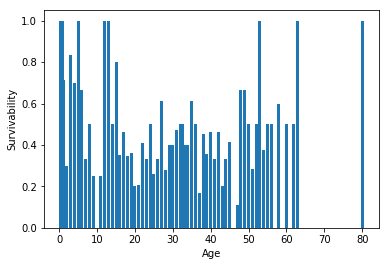

In [31]:
def making_bar(attribute):
    X_train['Survived'] = pd.Series(y_train)
    survivability = X_train.groupby([attribute])["Survived"].mean()
    values = X_train.groupby([attribute]).groups.keys()
    plt.bar(values, survivability)
    plt.ylabel('Survivability')
    plt.xlabel(attribute)

making_bar('Age')